# Deep Learning Mini Challenge 2

In [2]:
import pandas as pd
import os
import numpy as np
import h5py
import json
import torch
import torch.nn as nn
import torchvision.models as models
import spacy
import time
import matplotlib.pyplot as plt
import string
from PIL import Image

import torch.optim as optim
from torchvision import transforms
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, BatchSampler, Sampler
from torch.utils.tensorboard import SummaryWriter
from Utils import get_loader
from Utils import get_test_set

from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
import nltk
nltk.download('wordnet')

"""import requests
def send_tg_message(text='Cell execution completed.'):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=text)
    )"""

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


"import requests\ndef send_tg_message(text='Cell execution completed.'):\n    requests.post(\n        'https://api.telegram.org/' +\n        'bot{}/sendMessage'.format(tg_api_token), \n        params=dict(chat_id=tg_chat_id, text=text)\n    )"

## Data definition:

The data was taken from vizwiz.org/tasks-and-datasets/image-captioning. The main goal of the data set is to create captions for images for blind people. The data consists of over 23000 training images and almost 7800 validation images. There are also test images without annotations. Test images can be tested using real test users giving a human evaluation on computer generated captions. For every image there are 5 captions. In this document I used every caption seperately even though every image has 5 captions. I didn't figure out how use the information of 5 different captions to improve the generation of one caption for one image. All annoations are in designated json files where they are given foreign keys to their corresponding images. Therefore, I loaded each caption first and retrieved its foreign key to its correpsonding image. The images are in jpg and have a good resolution but a lot of them have noise and blur. They have colors, so the data that is fed into the model is in dimension: (batch size, channels (3 for rgb), height (300 after pytorch resize), width (300 after pytorch resize).

## Data preparation:

- download spacy en_core_web_sm
- define a dataset inheriting from pytorch' dataset class.  
- load captions with json.load
- save image link and captions of image 
- define vocabulary using all captions
	- start with defining a padding token, start of sequence token, end of sequence token and unknown token
	- tokenize with spacy_eng
- define the getitem function from the dataset:
	- load captions using ids from shuffled batches
	- load images based on foreign key for images in the captions json
	- numericalize captions based on vocabulary (if word is known, use unknown token)
- use MyCollate to collate batch
    - concatenate all images to one large tensor with dimensions : (batch size, rgb channels, height pxs, width pxs)
    - pad sequence on captions based on current batch and torch.nn.utils.rnn.pad_sequence()
- define a "get loader" function to load data and manage parameters
	- parameters: path to files, pytorch transformation composition (torchvision.transforms.Compose()), batch size, number of workers, shuffle (true/false), pin_memory (true/false)
    - transformation using down size, randomcrop and normalization

The above mentioned functionality is implemented in Utils.py

## Model training:

- train model with given hyperparameters
    - train per batch per epoch
    - calculate loss per batch and optimize the model through gradient descent after each batch
    - evaluate model to see loss function on validation pictures
    - save everything into a .csv after training
    - evaluate model with pictures and ROUGE and METEOR metrics. 
    - evaluate using own pictures

## Model specification:

The model uses a CNN as image encoder and an RNN (LSTM) as a decoder to produce text. The CNN is a pretrained Resnet18 model where all layers but the last one are frozen. Resnet18 was chosen because it's the smallest resnet CNN, it is easy to implement due to the models module from pytorch and it's been used for this type of task many times before. The last resnet layer is popped from the model and a custom linear layer is added that produces a vector the size of the "embed size". Finally, the last layer is also normalized using BatchNorm.

The RNN Model takes the last CNN layer and tries to decode it to a sequence of words. It uses pytorch's embedding to embed the captions per batch. In the internet example I found, they use dropout for this embedding step as well. Dropping some embeddings works for generalization. The lstm stops after the END token has been generated and returns the last cell state of the calculation. This output is then fed to a linear layer which can be used to calculate the loss function. Parameters were copied from internet examples or chosen to be as basic as possible to not blow up my PC. My GPU only has 4GB of dedicated memory, so I had to use a small batch size of 16 to not load giant batches all at the same time. 

More info:

- embed size of 250 (CNN "encodes" the images to the dimensions of the embed size)
- a large embedding size might lead to overfitting, a small embedding size to underfitting
- same hidden size as embed size, so the output of any lstm cell is 250
- LSTM with 7 layers
- LSTM feeds last hidden state to a linear layer
- learning rate 0.001. Played around with it, seems reasonable for batch size of 16.
- max epochs = 50
- Optimizer = Adam and Loss function = Cross Entropy Loss 

## Code for Model, Train and Evaluation:

In [7]:
%%time

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        
        #Transferlearning mit pretrained Resnet (das kleinste Modell von Resnet)
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        #Ein Linear Layer am Schluss, um die features ins LSTM zu laden
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        
        #nn.Emmbedding als Word Embedding nutzen
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        #LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        
        #Linear Layer am Schluss
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        
        
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
        
    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs
    
    def caption_image(self, image, vocabulary, max_length = 50):
        result_caption = []
        with torch.no_grad():
            
            x = self.encoderCNN(image).unsqueeze(1)
            states = None
        
            for i in range(max_length):
                
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]
    
# Detokenizer for printing
def detokenize_eng(tokens):
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens[1:-1]]).strip()

Wall time: 0 ns


In [8]:
%%time

# Define Train Function
def train(train_loader, val_loader, model, optimizer, embed_size, hidden_size, num_layers, max_epoch):
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache
    
    # Set Tensorboard
    writer = SummaryWriter("runs")
    step = 0
    
    # Initialize loss function and ignore padding tokens
    loss_fn = nn.CrossEntropyLoss(ignore_index = train_loader.dataset.vocab.stoi["<PAD>"])
    
    # Set Trackers
    epochs_list = []
    train_loss_list = []
    train_loss_val = []
    val_loss_list = []
    eta_list = []
    
    for epoch in range(max_epochs):
        print("start epoch")
        
        #more trackers
        correct = 0
        total_labels = 0
        total_loss = 0
        total_loss_val = 0
        
        t0 = time.time()
        
        # Per Epoch: Train Model   
        for idx, (imgs, captions) in enumerate(train_loader):
            
            with torch.autocast(device_type="cuda"):
                #set model to train mode
                model.train()

                imgs = imgs.to(device)
                captions = captions.to(device)

                #send all captions but last one so that it learns to predict the end token 
                outputs = model(imgs, captions[:-1])
                loss = loss_fn(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

                #loss gets updated after each batch, so a total loss is better to see if model is improving
                total_loss += loss.item()

                optimizer.zero_grad()
                loss.backward(loss)
                optimizer.step()
            
            torch.cuda.empty_cache
            
        print("Train Epoch Finished")
        
        avg_total_loss = total_loss / (idx + 1)

        t1 = time.time()
        eta = t1-t0
        eta_list.append(eta)
        
        # Per Epoch: Validate Model
        for idx, (imgs, captions) in enumerate(val_loader):
            with torch.autocast(device_type="cuda"):
                model.eval()

                imgs = imgs.to(device)
                captions = captions.to(device)

                outputs = model(imgs, captions[:-1])
                loss_val = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

                #loss gets updated after each batch, so a total loss is better to see if model is improving
                total_loss_val += loss_val.item()

                torch.cuda.empty_cache
        
        avg_total_loss_val = total_loss_val / (idx + 1)
        print("Validation Epoch Finished")
            
        print(f'Epoch: [{epoch+1}/{max_epochs}], average total train loss: {avg_total_loss}, train epoch time (s): {eta_list[-1:]}, average validation loss: {avg_total_loss_val}')
        epochs_list.append(epoch+1)
        train_loss_list.append(avg_total_loss)
        train_loss_val.append(avg_total_loss_val)
        writer.add_scalar("Training/Loss", loss.item())
    
    metrics_tracker = [{'epoch': epochs_list[i], 'train_loss': train_loss_list[i], 'training_time': eta_list[i], 'val_loss': train_loss_val[i]} for i in range(max_epochs)]
    torch.cuda.synchronize()  
    torch.cuda.empty_cache()
    return pd.DataFrame(metrics_tracker)

Wall time: 0 ns


In [9]:
%%time

# Set paths to results
metrics_path = "trained_history/"
saved_models_path = "trained_models/"

# Initialize Image Transformation for model
transform = transforms.Compose(
    [
        transforms.Scale((300,300)),
        transforms.RandomCrop((250,250)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Get train data loader
train_loader = get_loader("./train/", "./annotations/train.json", transform = transform, batch_size = 16, num_workers = 8)

# Get validation data loader
val_loader = get_loader("./val/", "./annotations/val.json", transform = transform, batch_size = 16, index_fixer = 23431, num_workers = 8)

# Initialize hyperparameters
embed_size = 250
hidden_size = 250
vocab_size = len(train_loader.dataset.vocab)
num_layers = 7
learning_rate = 0.001
max_epochs = 50

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Wall time: 8.09 s


In [4]:
%%time

# Train model
results = train(train_loader, val_loader, model, optimizer, embed_size, hidden_size, num_layers, max_epochs)

# Save model
run_name = "CNNtoRNN-resnet-18"
results.to_csv(metrics_path + run_name + ".csv", index=False)
torch.save(model, saved_models_path + run_name + ".pth")

# Send notification
"""tg_api_token = ''
tg_chat_id = ''
stra = f"Execution complete. Train Loss: {results[-1:].train_loss}, Time: {results[-1:].training_time.sum()/60}"
send_tg_message(stra)"""

C:\Users\bruno\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


start epoch
Train Epoch Finished
Validation Epoch Finished
Epoch: [1/50], average total train loss: 4.869331375649358, train epoch time (s): [156.201101064682], average validation loss: 5.79208433603503
start epoch
Train Epoch Finished
Validation Epoch Finished
Epoch: [2/50], average total train loss: 4.646823789642125, train epoch time (s): [143.4215850830078], average validation loss: 5.8533801599876165
start epoch
Train Epoch Finished
Validation Epoch Finished
Epoch: [3/50], average total train loss: 4.5909812668484635, train epoch time (s): [146.51314902305603], average validation loss: 5.875000890751475
start epoch
Train Epoch Finished
Validation Epoch Finished
Epoch: [4/50], average total train loss: 4.534331636298639, train epoch time (s): [165.41711926460266], average validation loss: 5.933536841205715
start epoch
Train Epoch Finished
Validation Epoch Finished
Epoch: [5/50], average total train loss: 4.289250632276307, train epoch time (s): [159.39934301376343], average validat

In [6]:
print("Total Training Time On GTX 970 Asus Strix: ", results.training_time.sum()/60, "min")

Total Training Time On GTX 970 Asus Strix:  144.7552646915118 min


## RougeL and Meteor of first 500 captions:

In [10]:
torch.cuda.empty_cache
model = torch.load(saved_models_path + "CNNtoRNN-resnet-18.pth")

model.eval()

test_loader = get_test_set("./val/", "./annotations/val.json", transform = transform, index_fixer = 23441)

In [5]:
%%time

rouge = 0
meteor = 0
N = len(test_loader)/2
print(f"Amount of Captions: {N}")
for caption in test_loader.captions:
    
    idx = caption["image_id"] - 23431
    
    img_idx = test_loader.images[idx]
    img = Image.open(os.path.join("val/"+img_idx)).convert("RGB")
    img = transform(img)
    predictions = detokenize_eng(model.caption_image(img.unsqueeze(0).to(device), train_loader.dataset.vocab))
    rouge += scorer.score(predictions.lower(), caption["caption"].lower())["rougeL"].precision
    meteor += single_meteor_score(predictions.lower().split(), caption["caption"].lower().split())
    
    if idx == 500:
        break

print(f"Average Rouge score. {rouge/N}. Average Meteor score: {meteor/N}")

Amount of Captions: 3875.0
Average Rouge score. 0.15669827301656214. Average Meteor score: 0.12939837618772565
Wall time: 3min 17s


## Sample Images:

From left to right showing real picture and picture after transformation: 

Prediction 1: a red and white striped fabric is shown.
Real Caption 1: Some fabric that is black and white striped like a referee's jersey as well as some pink material on top of that.

Prediction 2: a box of girl scout cookies on a white carpet.
Real Caption 2: Packaged box and lavender bottle with laundry detergent.

Prediction 3: a dog is sitting on the ground with a dog in their lap.
Real Caption 3: A white bulldog with brown spots sits on a hardwood floor and rug looking up.




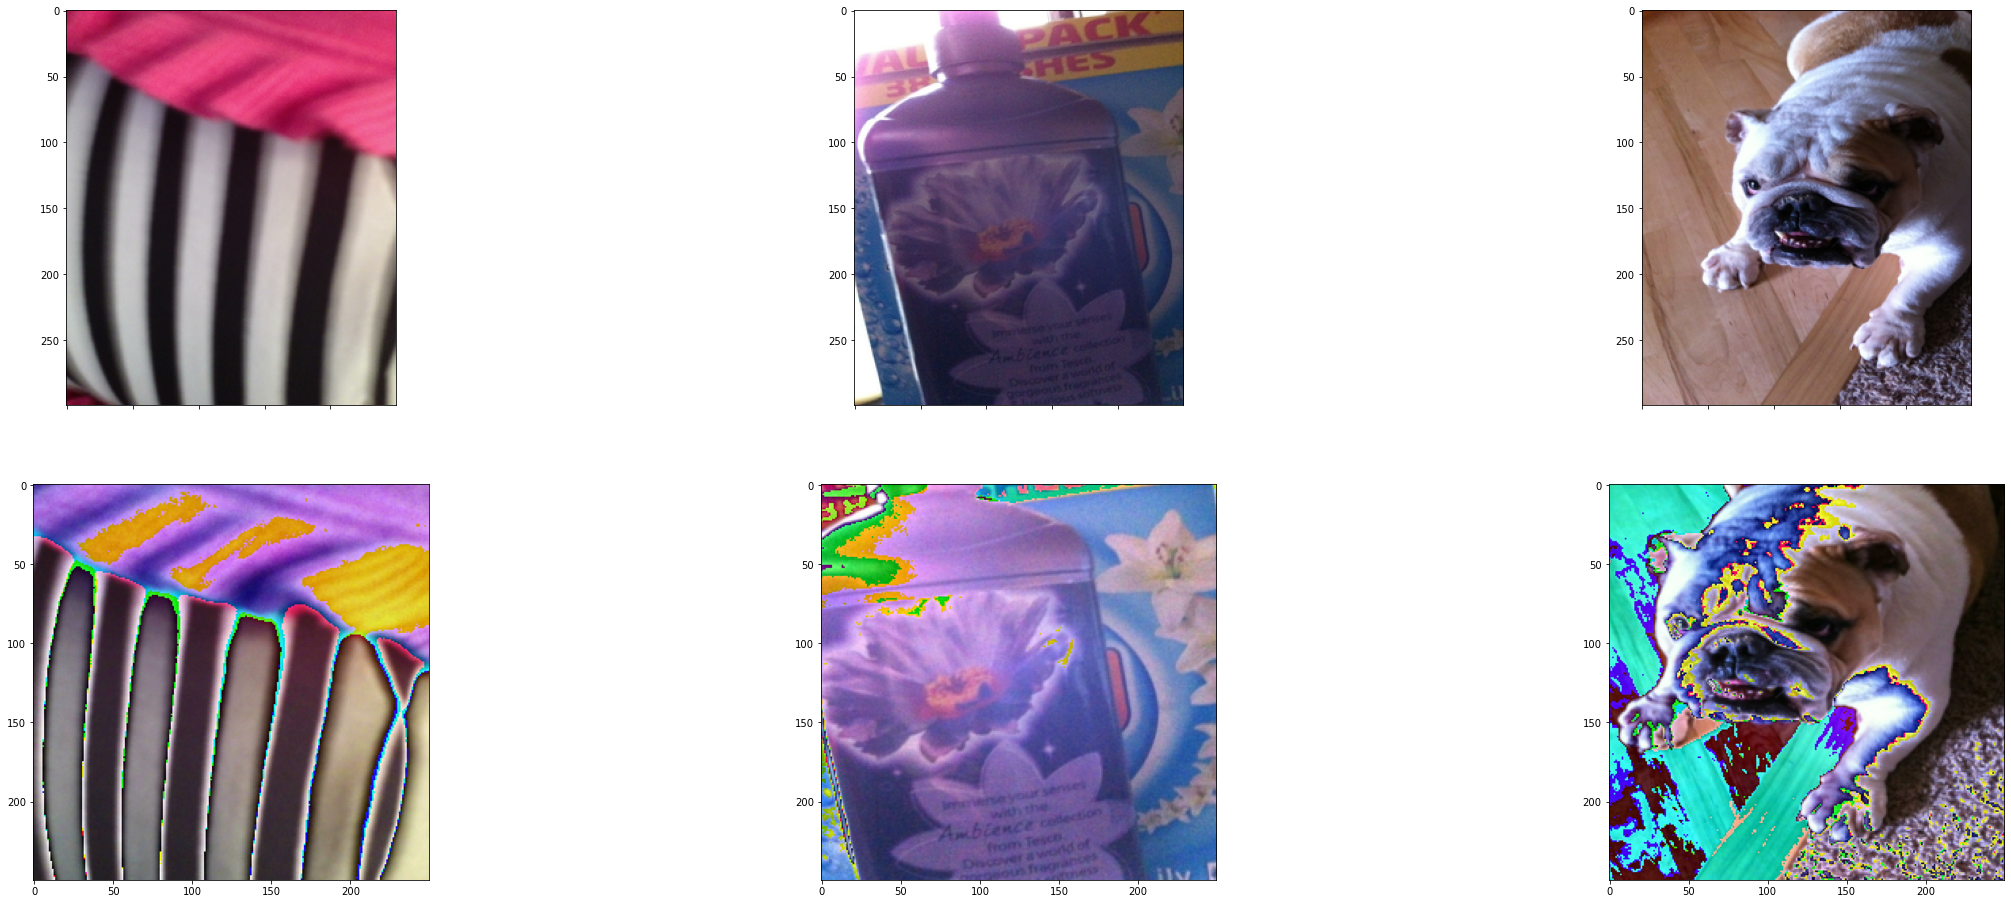

In [86]:
img_3550 = Image.open(os.path.join("val/VizWiz_val_00003550.jpg")).convert("RGB")
img_3550_caption = "Some fabric that is black and white striped like a referee's jersey as well as some pink material on top of that."

img_5855 = Image.open(os.path.join("val/VizWiz_val_00005855.jpg")).convert("RGB")
img_5855_caption = "Packaged box and lavender bottle with laundry detergent."

img_1681 = Image.open(os.path.join("val/VizWiz_val_00001681.jpg")).convert("RGB")
img_1681_caption = "A white bulldog with brown spots sits on a hardwood floor and rug looking up."

img_3550_transformed = transform(img_3550)
img_5855_transformed = transform(img_5855)
img_1681_transformed = transform(img_1681)

#show how they were trained
img_3550_train_transformed = transform(img_3550)
img_5855_train_transformed = transform(img_5855)
img_1681_train_transformed = transform(img_1681)

prediction_3550 = model.caption_image(img_3550_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)
prediction_5855 = model.caption_image(img_5855_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)
prediction_1681 = model.caption_image(img_1681_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)

prediction_3550 = detokenize_eng(prediction_3550)
prediction_5855 = detokenize_eng(prediction_5855)
prediction_1681 = detokenize_eng(prediction_1681)

fig1, axs1 = plt.subplots(2, 3, figsize=(40,16), sharex=True)

axs1[0,0].imshow(np.asarray(img_3550.resize((300, 300), Image.ANTIALIAS)))
axs1[0,1].imshow(np.asarray(img_5855.resize((300, 300), Image.ANTIALIAS)))
axs1[0,2].imshow(np.asarray(img_1681.resize((300, 300), Image.ANTIALIAS)))

axs1[1,0].imshow(np.asarray(transforms.ToPILImage()(img_3550_train_transformed).convert("RGB")))
axs1[1,1].imshow(np.asarray(transforms.ToPILImage()(img_5855_train_transformed).convert("RGB")))
axs1[1,2].imshow(np.asarray(transforms.ToPILImage()(img_1681_train_transformed).convert("RGB")))

print("From left to right showing real picture and picture after transformation: \n")
print(f"Prediction 1: {prediction_3550}\nReal Caption 1: {img_3550_caption}")
print(f"\nPrediction 2: {prediction_5855}\nReal Caption 2: {img_5855_caption}")
print(f"\nPrediction 3: {prediction_1681}\nReal Caption 3: {img_1681_caption}")
print("\n")

#axs1[1,0].set_xlabel("Prediction: " + prediction_3550+"\n\n"+"Real Caption: " + img_3550_caption, fontsize=13, loc='left')
#axs1[1,1].set_xlabel("Prediction: " + prediction_5855+"\n\n"+"Real Caption: " + img_5855_caption, fontsize=18, loc='left')
#axs1[1,2].set_xlabel("Prediction: " + prediction_1681+"\n\n"+"Real Caption: " + img_1681_caption, fontsize=18, loc='left')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

## Test on my own pictures:

In [98]:
car = Image.open(os.path.join("personal_test/car.jpg")).convert("RGB")
key = Image.open(os.path.join("personal_test/key.jpg")).convert("RGB")
cooki = Image.open(os.path.join("personal_test/cooki.jpg")).convert("RGB")
banana = Image.open(os.path.join("personal_test/banana.jpg")).convert("RGB")
unk = Image.open(os.path.join("personal_test/unk.jpg")).convert("RGB")
unk2 = Image.open(os.path.join("personal_test/unk2.jpg")).convert("RGB")

#show how they were trained
img_car_transformed = transform(car)
img_key_transformed = transform(key)
img_cooki_transformed = transform(cooki)
img_banana_transformed = transform(banana)
img_unk_transformed = transform(unk)
img_unk2_transformed = transform(unk2)

prediction_car = model.caption_image(img_car_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)
prediction_key = model.caption_image(img_key_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)
prediction_cooki = model.caption_image(img_cooki_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)
prediction_banana = model.caption_image(img_banana_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)
prediction_unk = model.caption_image(img_unk_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)
prediction_unk2 = model.caption_image(img_unk2_transformed.unsqueeze(0).to(device), train_loader.dataset.vocab)

prediction_car = detokenize_eng(prediction_car)
prediction_key = detokenize_eng(prediction_key)
prediction_cooki = detokenize_eng(prediction_cooki)
prediction_banana = detokenize_eng(prediction_banana)
prediction_unk = detokenize_eng(prediction_unk)
prediction_unk2 = detokenize_eng(prediction_unk2)

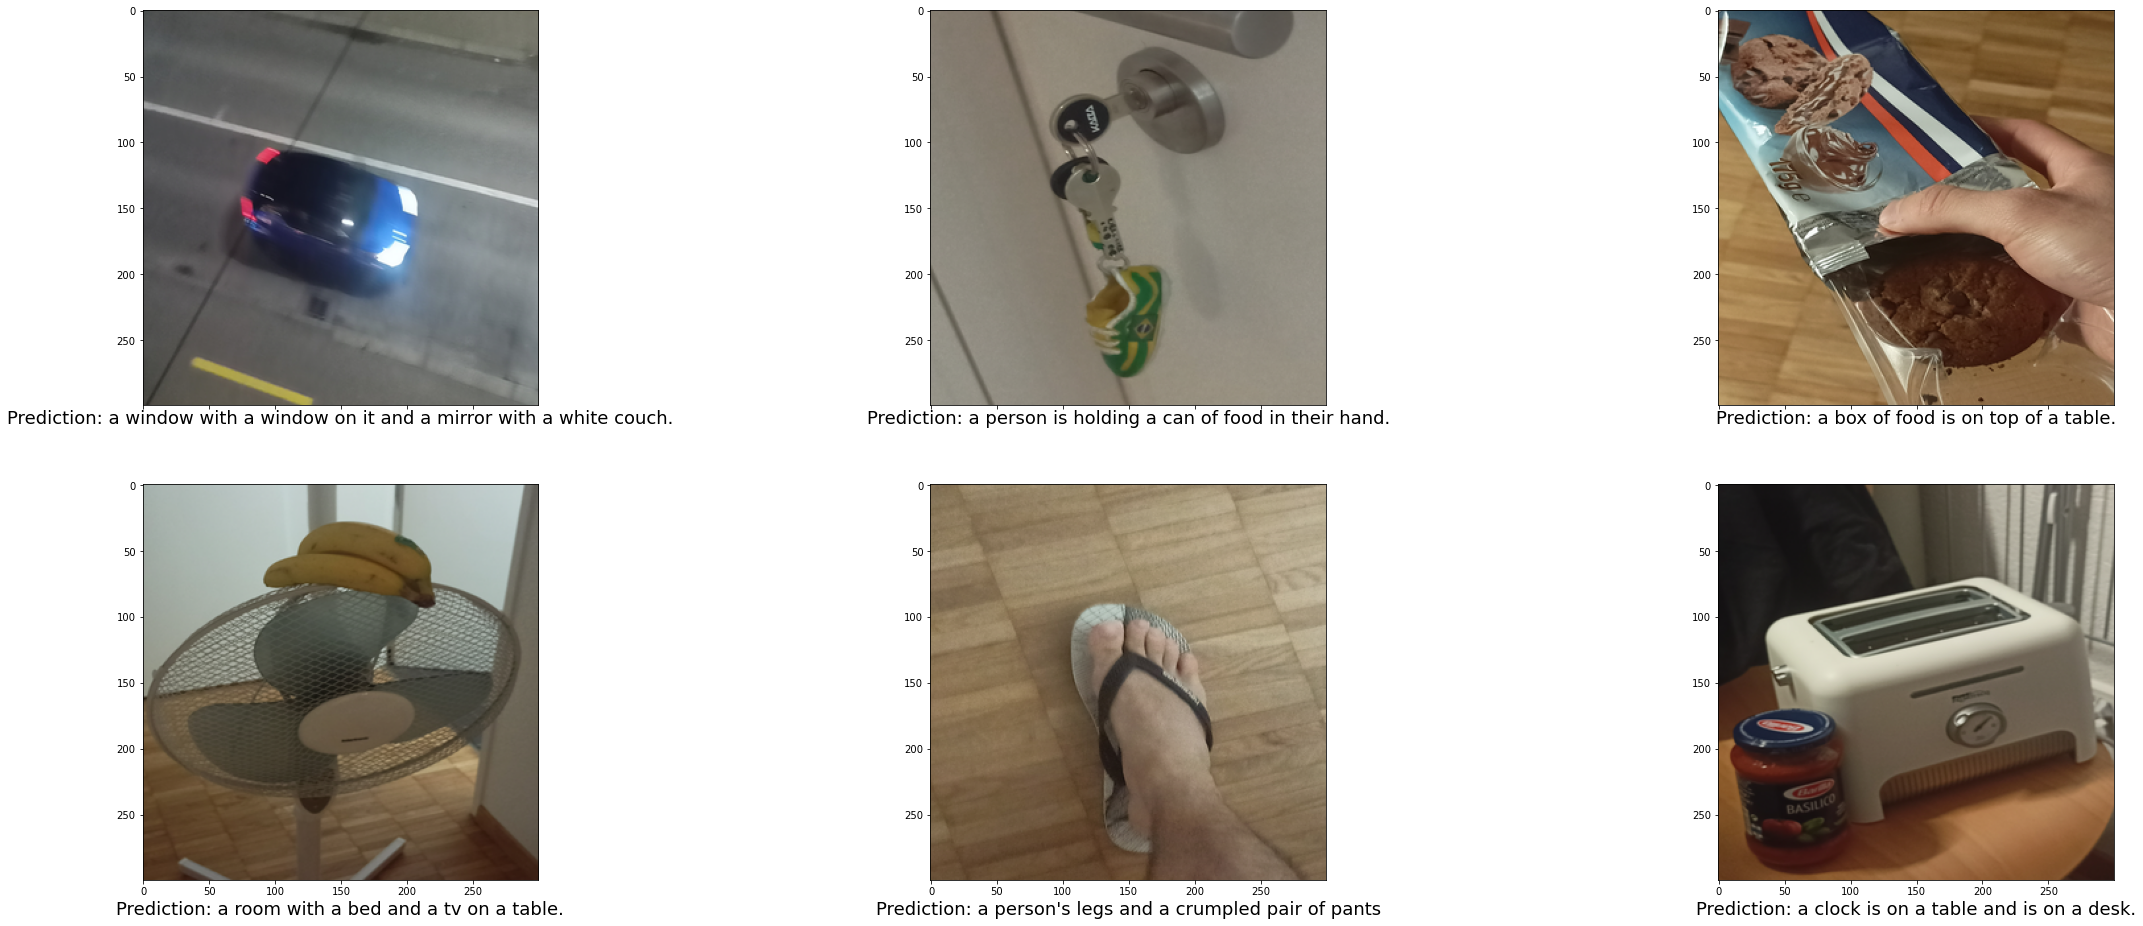

In [99]:
fig1, axs1 = plt.subplots(2, 3, figsize=(40,16), sharex=True)

axs1[0,0].imshow(np.asarray(car.resize((300, 300), Image.ANTIALIAS)))
axs1[0,1].imshow(np.asarray(key.resize((300, 300), Image.ANTIALIAS)))
axs1[0,2].imshow(np.asarray(cooki.resize((300, 300), Image.ANTIALIAS)))

axs1[1,0].imshow(np.asarray(banana.resize((300, 300), Image.ANTIALIAS)))
axs1[1,1].imshow(np.asarray(unk.resize((300, 300), Image.ANTIALIAS)))
axs1[1,2].imshow(np.asarray(unk2.resize((300, 300), Image.ANTIALIAS)))

axs1[0,0].set_xlabel("Prediction: " + prediction_car, fontsize=18)
axs1[0,1].set_xlabel("Prediction: " + prediction_key, fontsize=18)
axs1[0,2].set_xlabel("Prediction: " + prediction_cooki, fontsize=18)

axs1[1,0].set_xlabel("Prediction: " + prediction_banana, fontsize=18)
axs1[1,1].set_xlabel("Prediction: " + prediction_unk, fontsize=18)
axs1[1,2].set_xlabel("Prediction: " + prediction_unk2, fontsize=18)

#plt.tight_layout()
plt.show()

## Model Discussion:

Looking at the predictions of random samples, the model picked up the stripes and general context of the first picture pretty well. The dog is also classified. I'm pretty sure the model picks up dogs and clothes better than other random stuff. The training data probably has some fairly good pictures of dogs and the pretrained Resnet has probably also been trained on dog pictures. In my personal pictures, the model correctly classifies my foot/leg and also the clock on my toaster. The model also picks up on the food packaging for cookies.
Interestingly enough, the model associates the fan with a room with a bed and a TV. This makes sense because pictures of random rooms might show a fan next to a TV or a bed. 

The model wasn't trained to be one-to-many even though multiple captions exist for each image. I am not sure how to incorporate more captions to provide better prediction results. We can see that the scores for the validation set is pretty bad but none the less if we look at the predictions ourselves we can see some information that the model has picked up. For example .... The validation set has some very random pictures where even humans fails. Also there are a lot of blurred and close-up pictures with bad quality.

Due to lack of time I couldn't train the model with different combinations of parameters but after 50 epochs with the base model we can see substantial improvement in the model loss function. What I haven't figured out is that the evaluation loss goes up over time. Maybe cross entropy loss is not ideal for evaluating the validation data set. The training history CSV is [here](trained_history/CNNtoRNN-resnet-18.csv).

The rougeL and meteor score show similar values. Both show that the predicted captions capture *some* of the image content.  

The following plot shows the training loss over epochs. It also shows how the validation loss increases. After 50 epochs the training loss hasn't stagnated.

<Figure size 720x720 with 0 Axes>

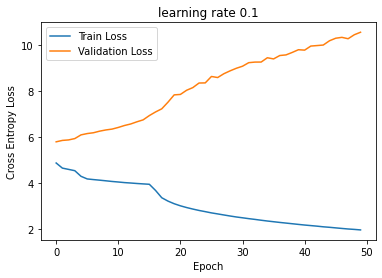

<Figure size 720x720 with 0 Axes>

In [106]:
losses = pd.read_csv(metrics_path + "CNNtoRNN-resnet-18.csv")

figure, axis = plt.subplots(1, 1)

axis.plot(losses.train_loss, label="Train Loss")
axis.plot(losses.val_loss, label="Validation Loss")

axis.set_title("learning rate 0.1")
axis.legend()

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss') 

plt.figure(figsize=(10, 10))